
# Drivers that effect the outcome of UFC fights

## Project Overview

In this project, I will be working with a ufc data set to discover which attributes effect the outcome of a UFC fight.


## Project Description

I will be using classification machine learning algorithms to discover the best model at predicting statistical signficance in the outcome of UFC fights. The data set I will be working with is downloadable from the kaggle servers. Specifically the years 1993 - 2019

## Project Goal

Goals: Build a classification model to analyze the drivers of an outcome for a UFC fight

## Executive Summary



Best Features: average submission attempts, reach, average significant strikes, average ground attempts, and average control time(seconds).

Takeaways: My test accuracy of 63% did not beat my baseline of 65% 

## Hypothesis

- More submission attempts and ctrl time will effect the outcome
- The more rounds fought the more likely to win
- Reach and hieght will effect the outcome of a win
- Landing more sig shots will effect the outcome



In [1]:
#imports
import os
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score,precision_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from wrangle import train_validate_test_split,impute_nulls, split_X_y
from explore import explore_univariate, get_ufc_heatmap, explore_multivariate, plot_swarm_grid_with_color, plot_violin_grid_with_color
from acquire import summarize_df, new_ufc
from prepare import prepare_ufc, train_validate_test
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text, export_graphviz
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, explained_variance_score
from sklearn.ensemble import RandomForestClassifier
import statsmodels.api as sm
import sklearn.metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn import svm, naive_bayes

# Acquire 

In [2]:
## acquire our data from our local csv

df = new_ufc()
# 6012 rows and 143 columns
df

B_fighter        Referee        date  \
R_fighter                                                      
Adrian Yanez        Gustavo Lopez  Chris Tognoni  2021-03-20   
Trevin Giles        Roman Dolidze      Herb Dean  2021-03-20   
Tai Tuivasa       Harry Hunsucker      Herb Dean  2021-03-20   
Cheyanne Buys   Montserrat Conejo     Mark Smith  2021-03-20   
Marion Reneau       Macy Chiasson     Mark Smith  2021-03-20   
...                           ...            ...         ...   
Remco Pardoel  Alberta Cerra Leon  John McCarthy  1994-03-11   
Orlando Wiet     Robert Lucarelli  John McCarthy  1994-03-11   
Johnny Rhodes       David Levicki  John McCarthy  1994-03-11   
Patrick Smith          Ray Wizard  John McCarthy  1994-03-11   
Scott Morris       Sean Daugherty  John McCarthy  1994-03-11   

                             location Winner  title_bout       weight_class  \
R_fighter                                                                     
Adrian Yanez   Las Vegas, Nevada, USA    Red       False       Bantamweight   
Trevin Giles   Las Vegas, Nevada, USA    Red       False       Middleweight   
Tai Tuivasa    Las Vegas, Nevada, USA    Red       False        Heavyweight   
Cheyanne Buys  Las Vegas, Nevada, USA   Blue       False   WomenStrawweight   
Marion Reneau  Las Vegas, Nevada, USA   Blue       False  WomenBantamweight   
...                               ...    ...         ...                ...   
Remco Pardoel   Denver, Colorado, USA    Red       False         OpenWeight   
Orlando Wiet    Denver, Colorado, USA    Red       False         OpenWeight   
Johnny Rhodes   Denver, Colorado, USA    Red       False         OpenWeight   
Patrick Smith   Denver, Colorado, USA    Red       False         OpenWeight   
Scott Morris    Denver, Colorado, USA    Red       False         OpenWeight   

               B_avg_KD  B_avg_opp_KD  B_avg_SIG_STR_pct  ...  \
R_fighter                                                 ...   
Adrian Yanez      0.000           0.0           0.420000  ...   
Trevin Giles      0.500           0.0           0.660000  ...   
Tai Tuivasa         NaN           NaN                NaN  ...   
Cheyanne Buys       NaN           NaN                NaN  ...   
Marion Reneau     0.125           0.0           0.535625  ...   
...                 ...           ...                ...  ...   
Remco Pardoel       NaN           NaN                NaN  ...   
Orlando Wiet        NaN           NaN                NaN  ...   
Johnny Rhodes       NaN           NaN                NaN  ...   
Patrick Smith       NaN           NaN                NaN  ...   
Scott Morris        NaN           NaN                NaN  ...   

               R_win_by_Decision_Unanimous  R_win_by_KO/TKO  \
R_fighter                                                     
Adrian Yanez                             0                1   
Trevin Giles                             0                3   
Tai Tuivasa                              1                3   
Cheyanne Buys                            0                0   
Marion Reneau                            1                2   
...                                    ...              ...   
Remco Pardoel                            0                0   
Orlando Wiet                             0                0   
Johnny Rhodes                            0                0   
Patrick Smith                            0                0   
Scott Morris                             0                0   

               R_win_by_Submission  R_win_by_TKO_Doctor_Stoppage  R_Stance  \
R_fighter                                                                    
Adrian Yanez                     0                             0  Orthodox   
Trevin Giles                     0                             0  Orthodox   
Tai Tuivasa                      0                             0  Southpaw   
Cheyanne Buys                    0                             0    Switch   
Marion Reneau                

In [3]:
# looking at my nulls
df.isnull().sum()

B_fighter         0
Referee          32
date              0
location          0
Winner            0
               ... 
R_Height_cms      4
R_Reach_cms     406
R_Weight_lbs      2
B_age           172
R_age            63
Length: 143, dtype: int64

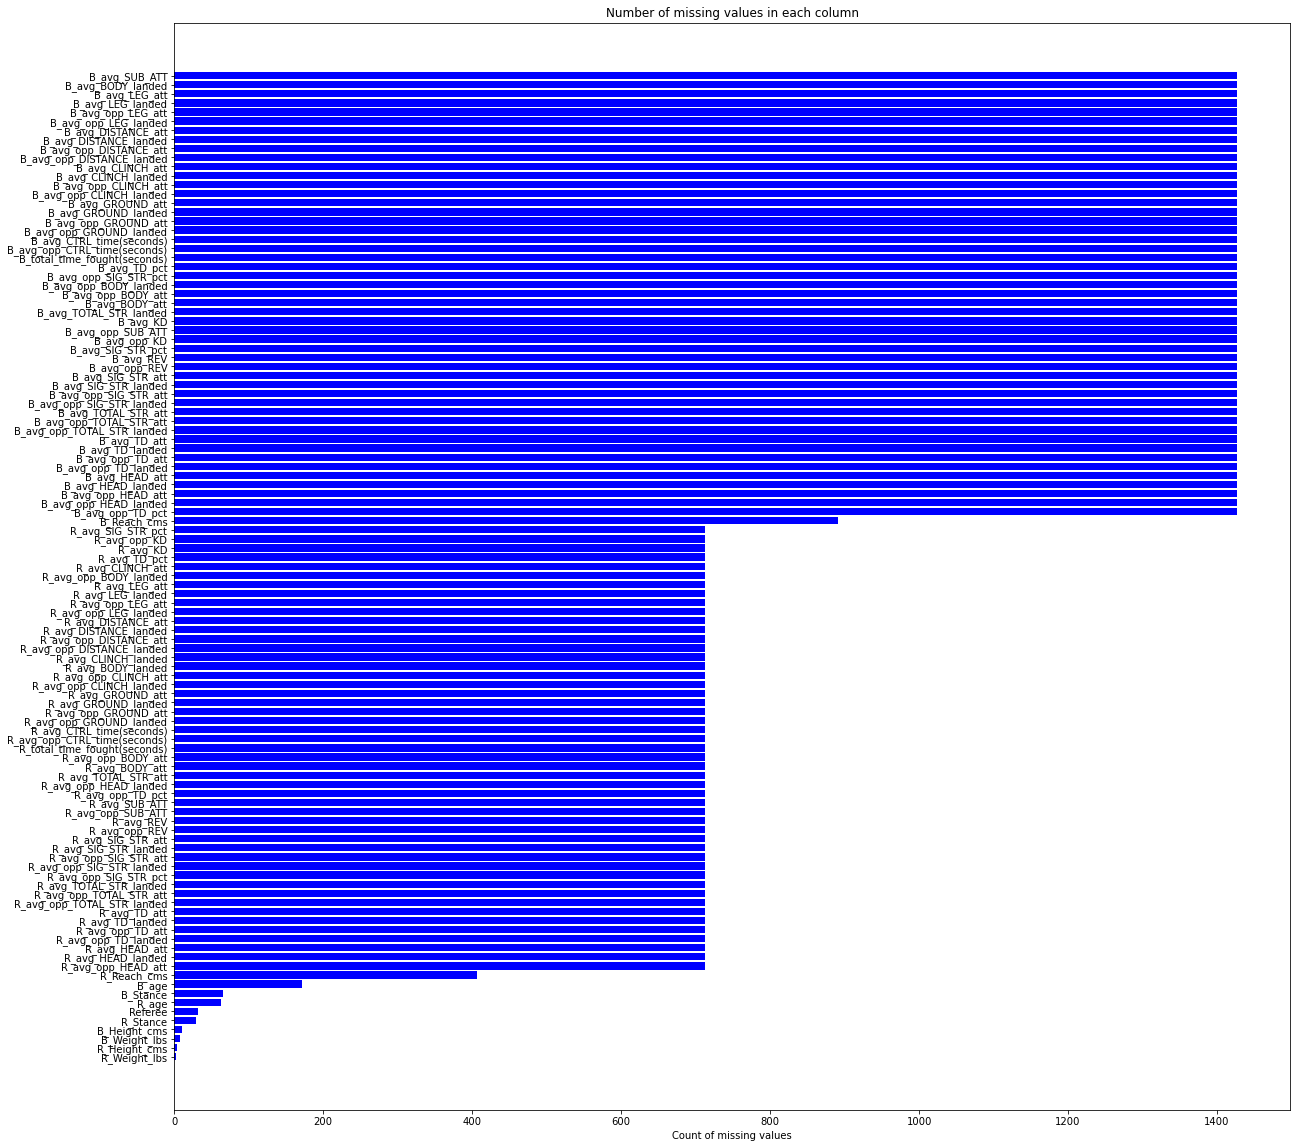

In [4]:
# visualize missing values

missing_df = df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df.loc[missing_df['missing_count']>0]
missing_df = missing_df.sort_values(by='missing_count')

ind = np.arange(missing_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(20,20))
rects = ax.barh(ind, missing_df.missing_count.values, color='blue')
ax.set_yticks(ind)
ax.set_yticklabels(missing_df.column_name.values, rotation='horizontal')
ax.set_xlabel("Count of missing values")
ax.set_title("Number of missing values in each column")
plt.show()

### Takeaways

- Lots of columns and null values
- Some columns can be imputed

# Prepare Data

In [5]:
df = prepare_ufc()


In [6]:
"""
Encoding match results
Red win = 1, Red lose = 0 & draw = 2
Did not use label encoder, because it labels in Alphabetical order
"""
match_results = df.loc[:,'Winner']
match_results_list = match_results.tolist()
matchList = []
#print(match_results_list)
for results in match_results_list:
    if "Blue" in results:
        matchList.append("0")
    elif "Red" in results: 
        matchList.append("1")
    else:
        matchList.append("2")
        
resultValues = np.array(matchList)
#Dropping previous 'Winner' column
df.drop(['Winner'], axis=1, inplace = True)
#Adding results into DF
df.insert(6, 'Winner', resultValues)

#Dropping Draw winners
df.drop(df[df['Winner'] == '2' ].index , inplace=True)
df['Winner'] = pd.to_numeric(df['Winner'])


  

In [7]:
# save to csv file
df.to_csv("ufc.csv", index=False)

In [8]:
# #let's split our data using my train_validate_test function, and check our train, validate, and test shapes. Our target is Winner.
target = 'Winner'
train, validate, test, X_train, y_train, X_validate, y_validate, X_test, y_test = train_validate_test(df, target)
train.shape, validate.shape, test.shape

((2138, 72), (917, 72), (764, 72))

### Takeaways

- After imputing columns with median and most frequent, nulls were dropped
- Stances column dropped due to string value and no real use
- Gender column was added
- Stance was encoded with numerics 1-4
- Match was encoded with 1 = Red win, 0 = Red lose, 2 = draw
- Title bout was encoded with 1 for True and 0 for False
- All of B oppenant columns were dropped so we can focus on the red winners since they had the most wins
- Finally our data was split into train validate and test
- We are now working with 3819 observations and 72 feature columns

# Explore 

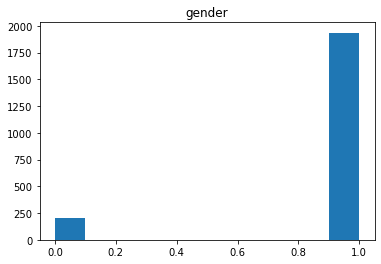

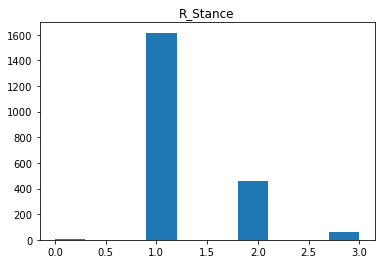

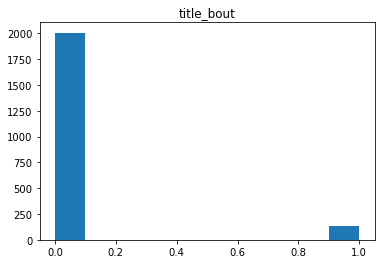

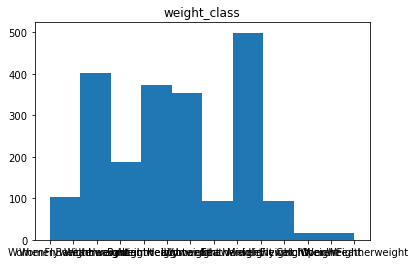

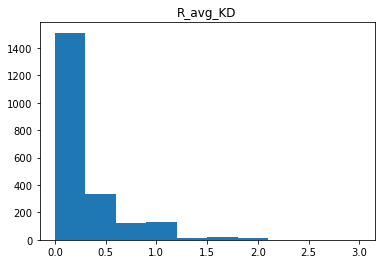

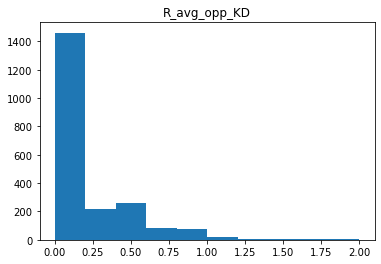

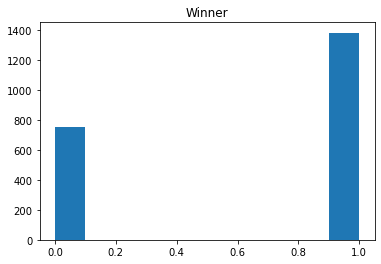

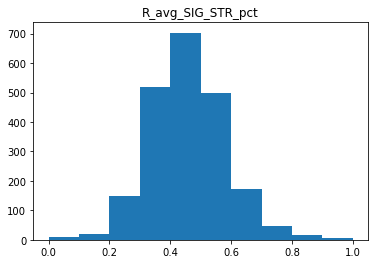

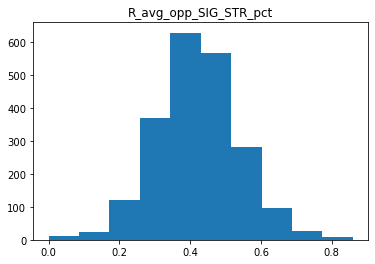

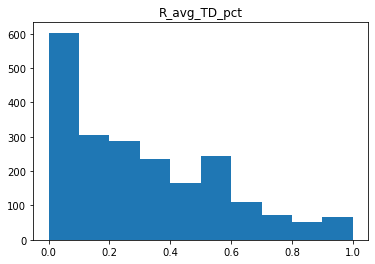

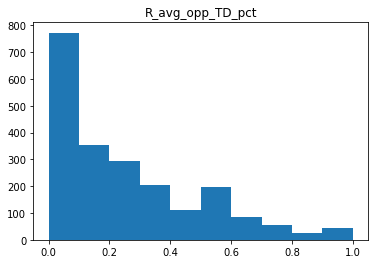

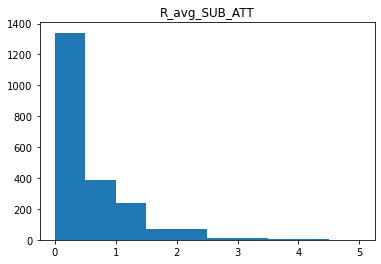

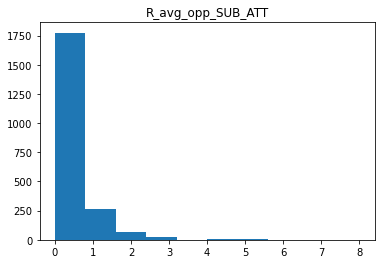

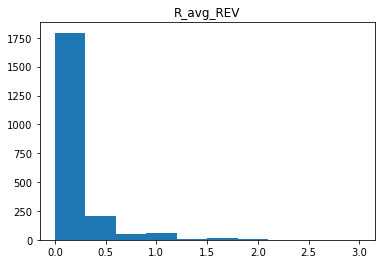

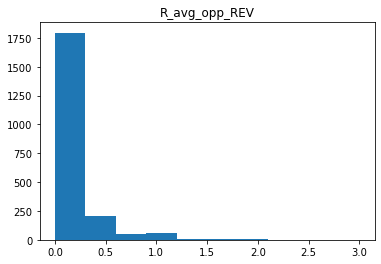

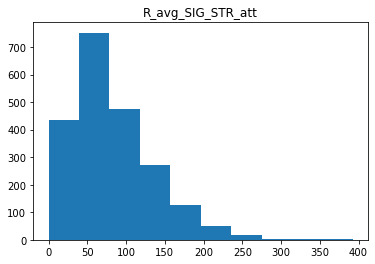

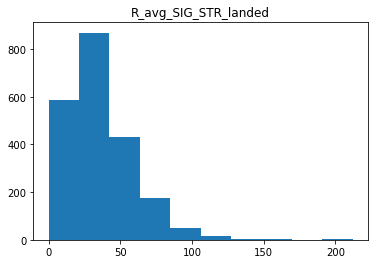

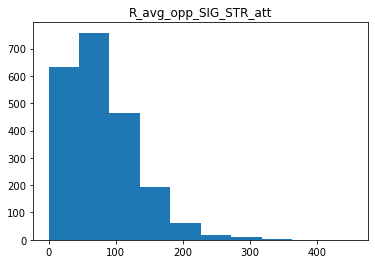

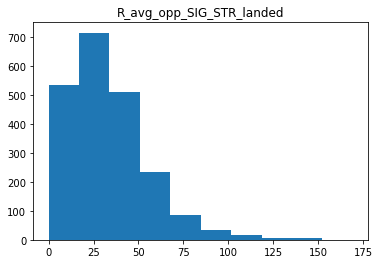

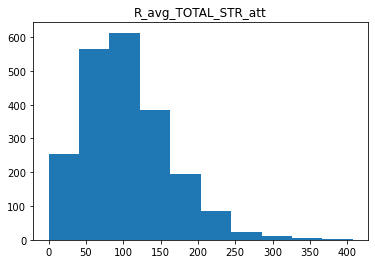

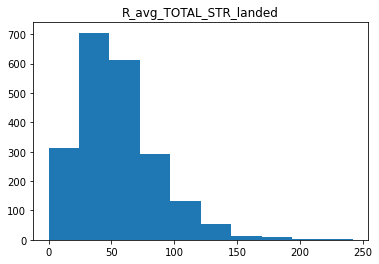

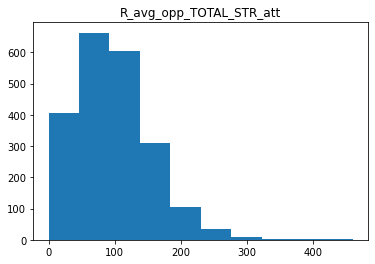

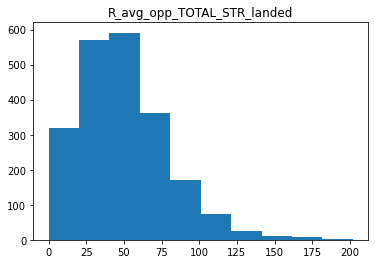

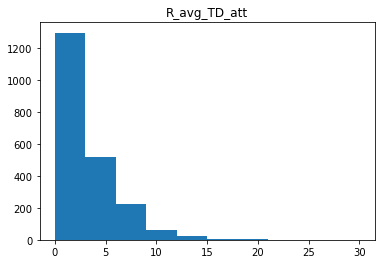

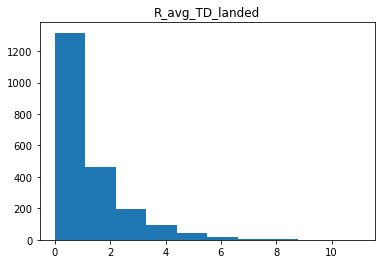

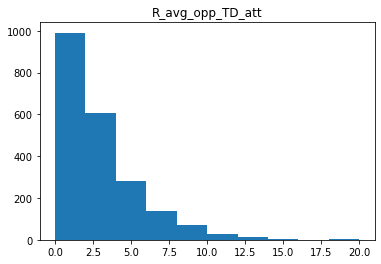

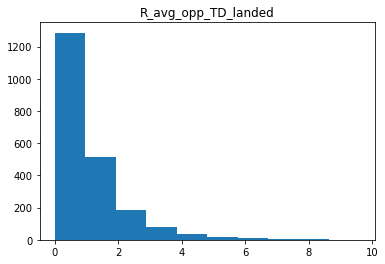

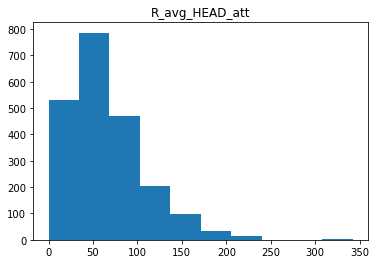

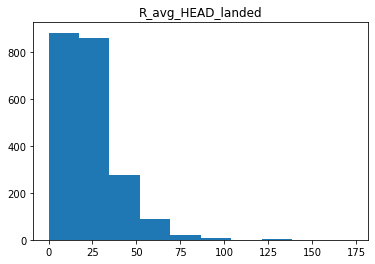

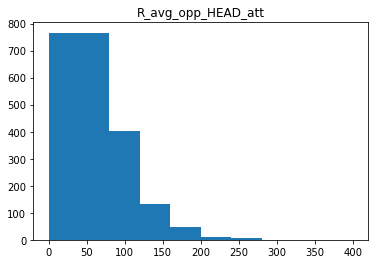

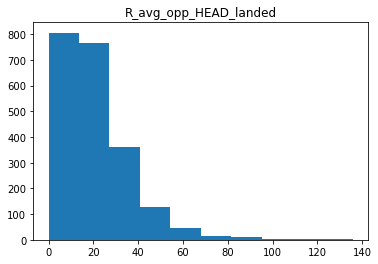

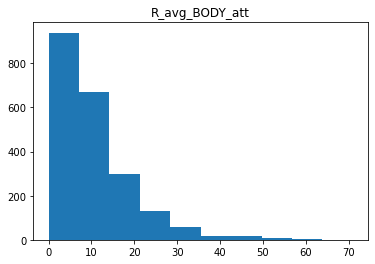

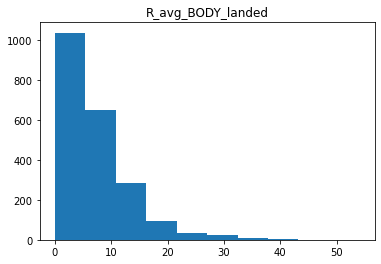

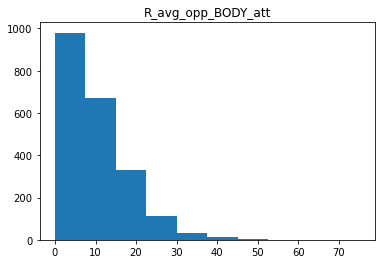

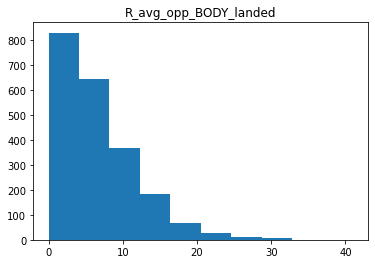

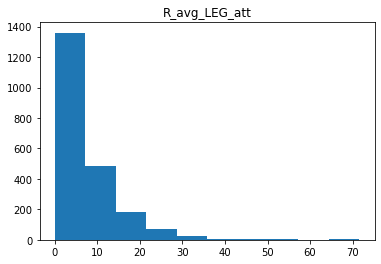

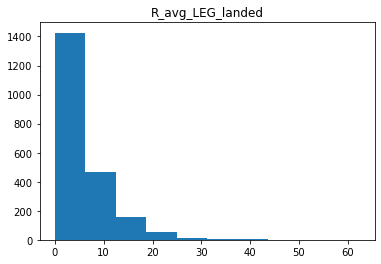

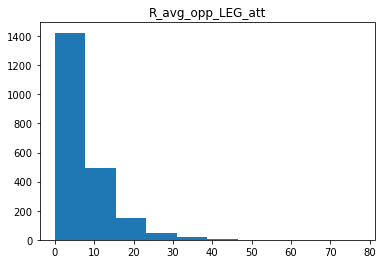

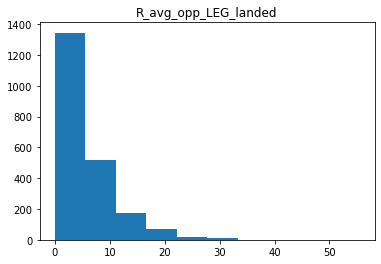

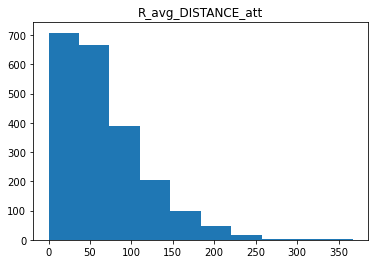

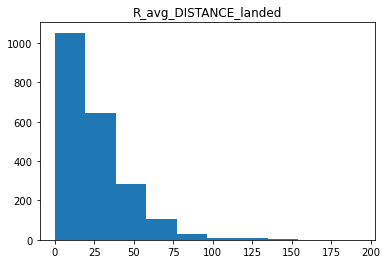

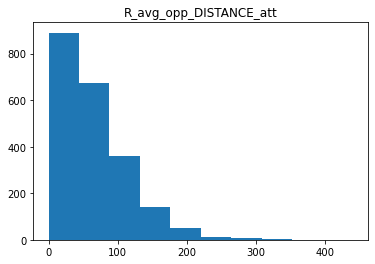

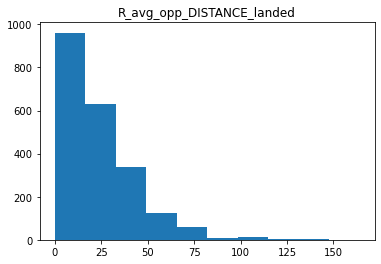

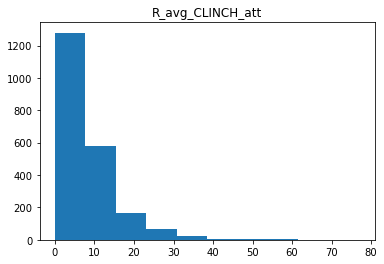

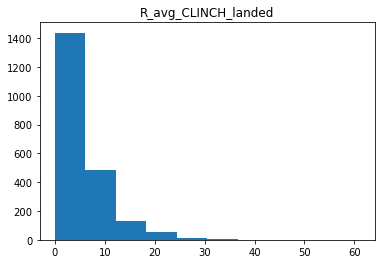

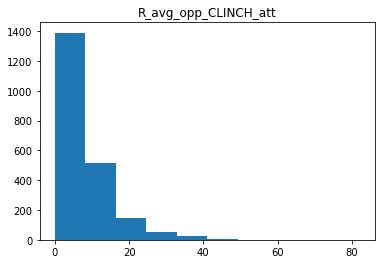

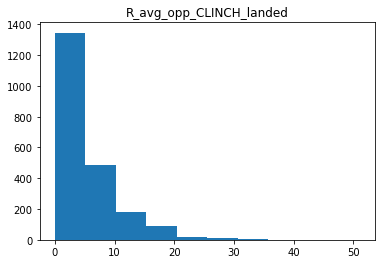

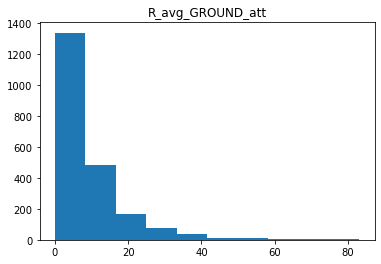

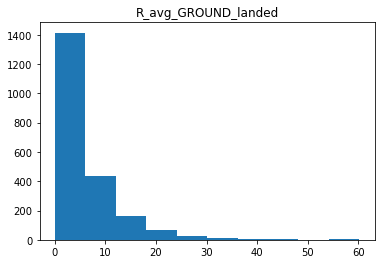

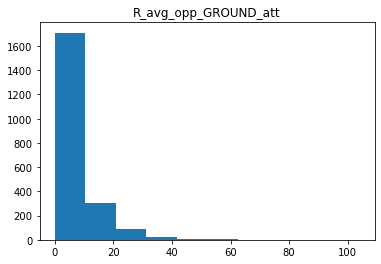

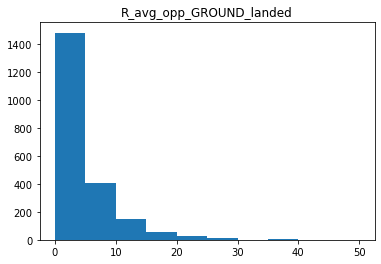

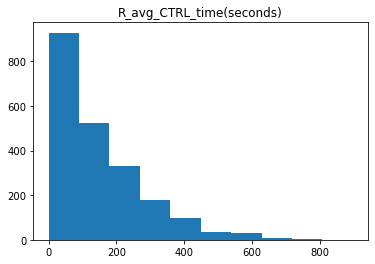

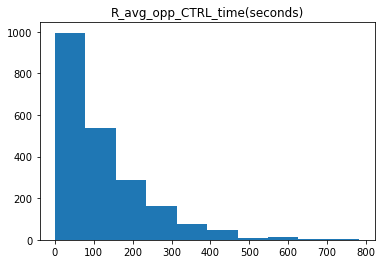

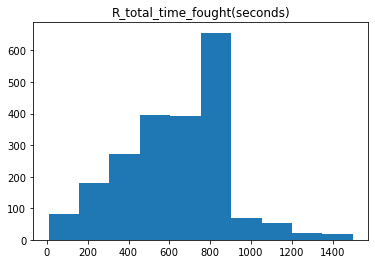

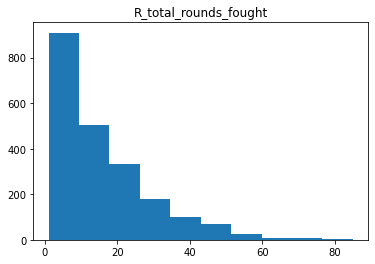

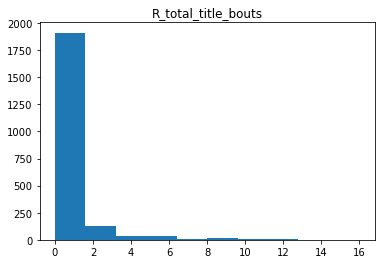

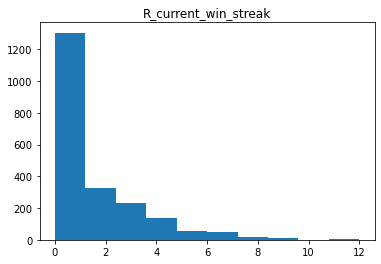

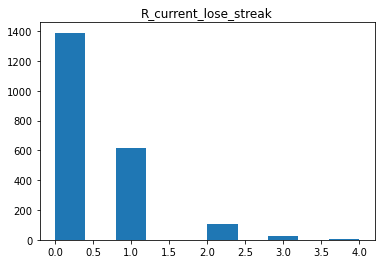

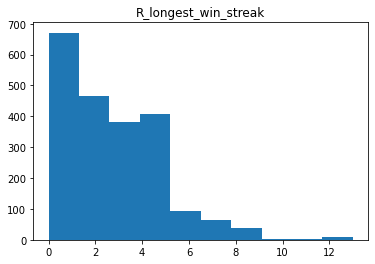

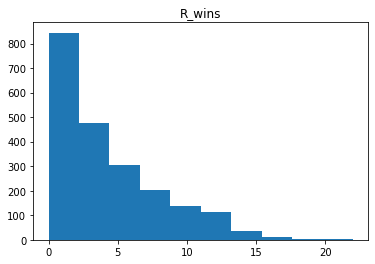

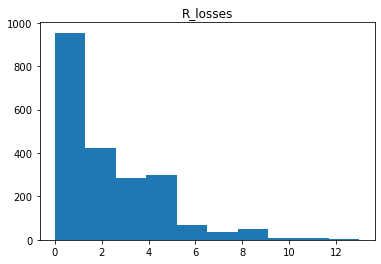

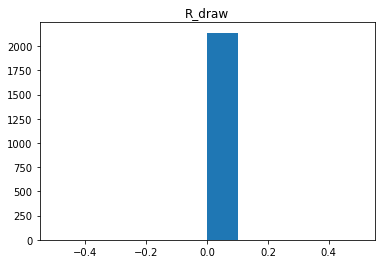

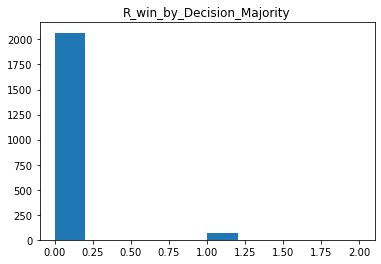

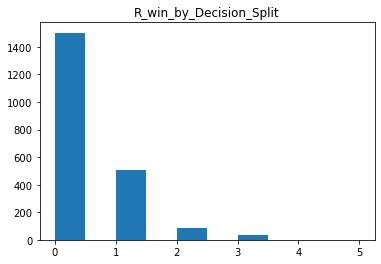

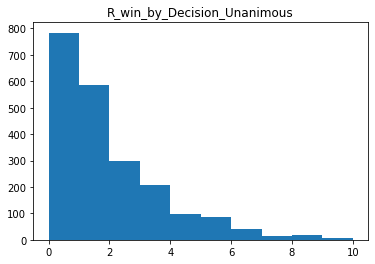

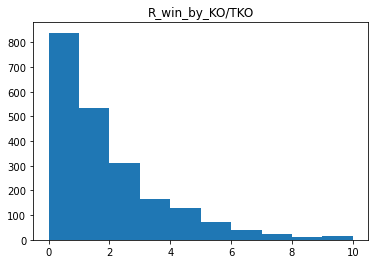

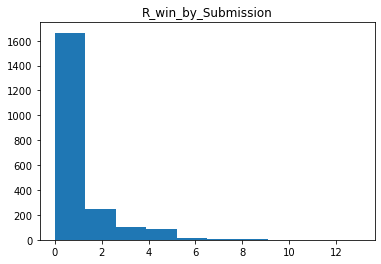

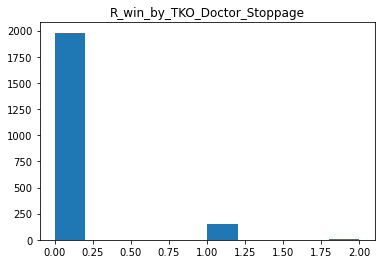

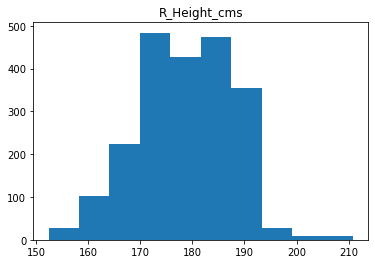

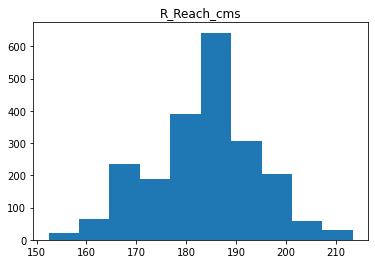

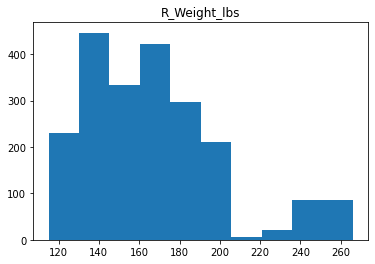

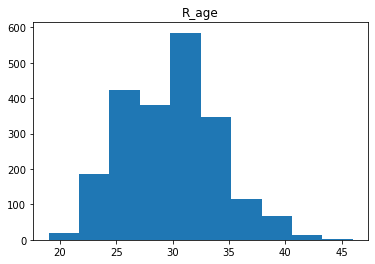

In [9]:
# Univariate exploration
for col in train.columns:
    plt.hist(train[col])
    plt.title(col)
    plt.show()

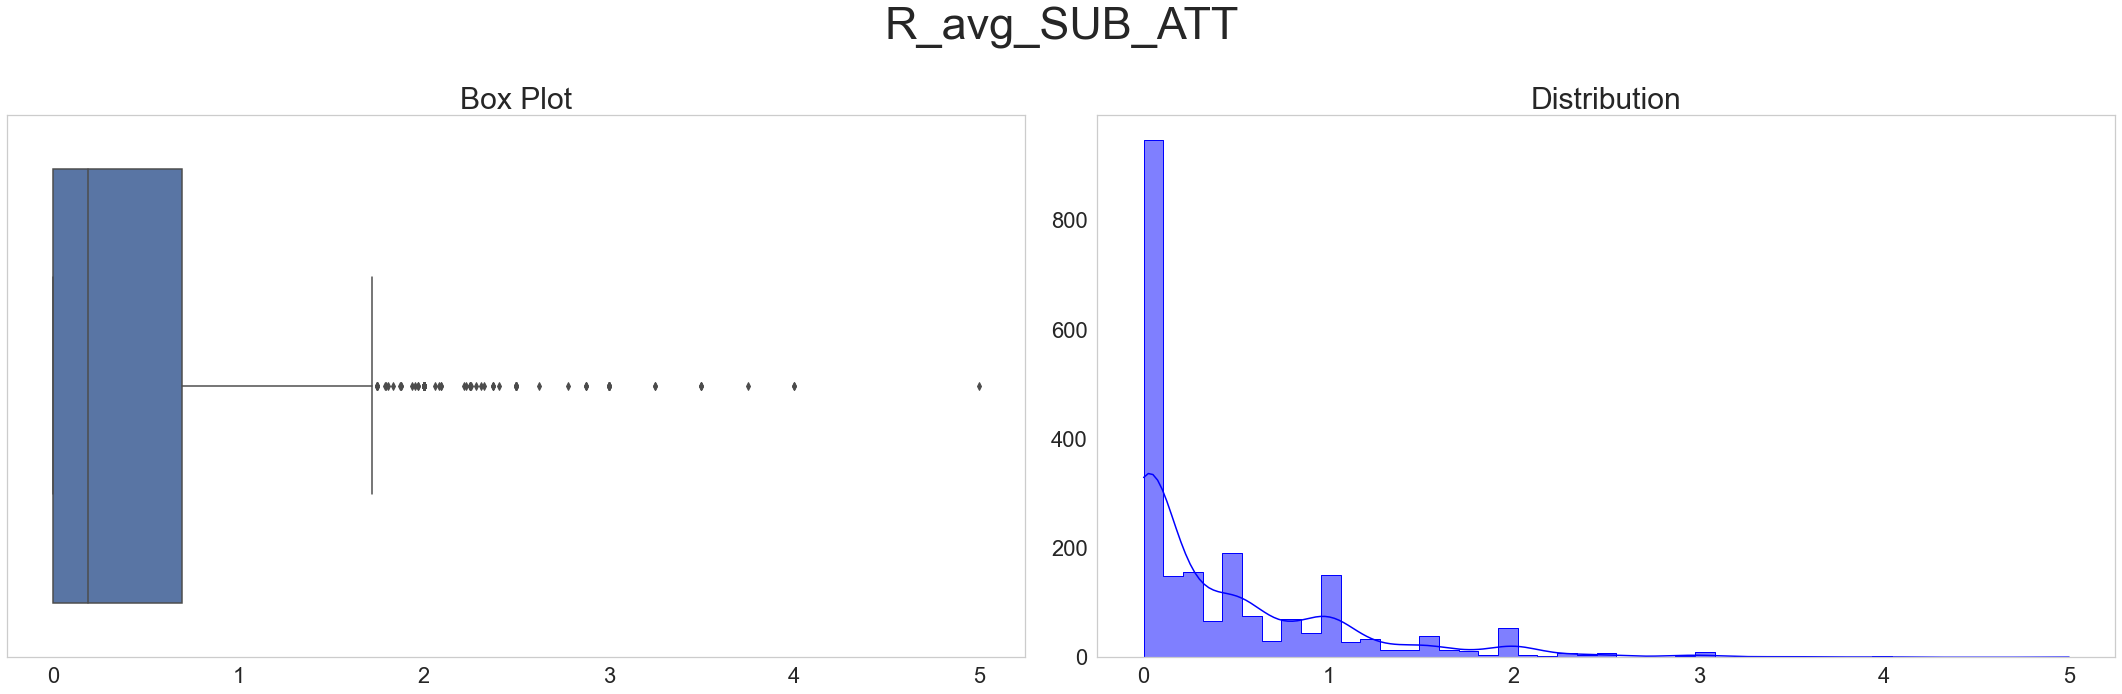

Summary Statistics for R_avg_SUB_ATT
count    2138.000000
mean        0.450484
std         0.621308
min         0.000000
25%         0.000000
50%         0.187500
75%         0.692871
max         5.000000
Name: R_avg_SUB_ATT, dtype: float64


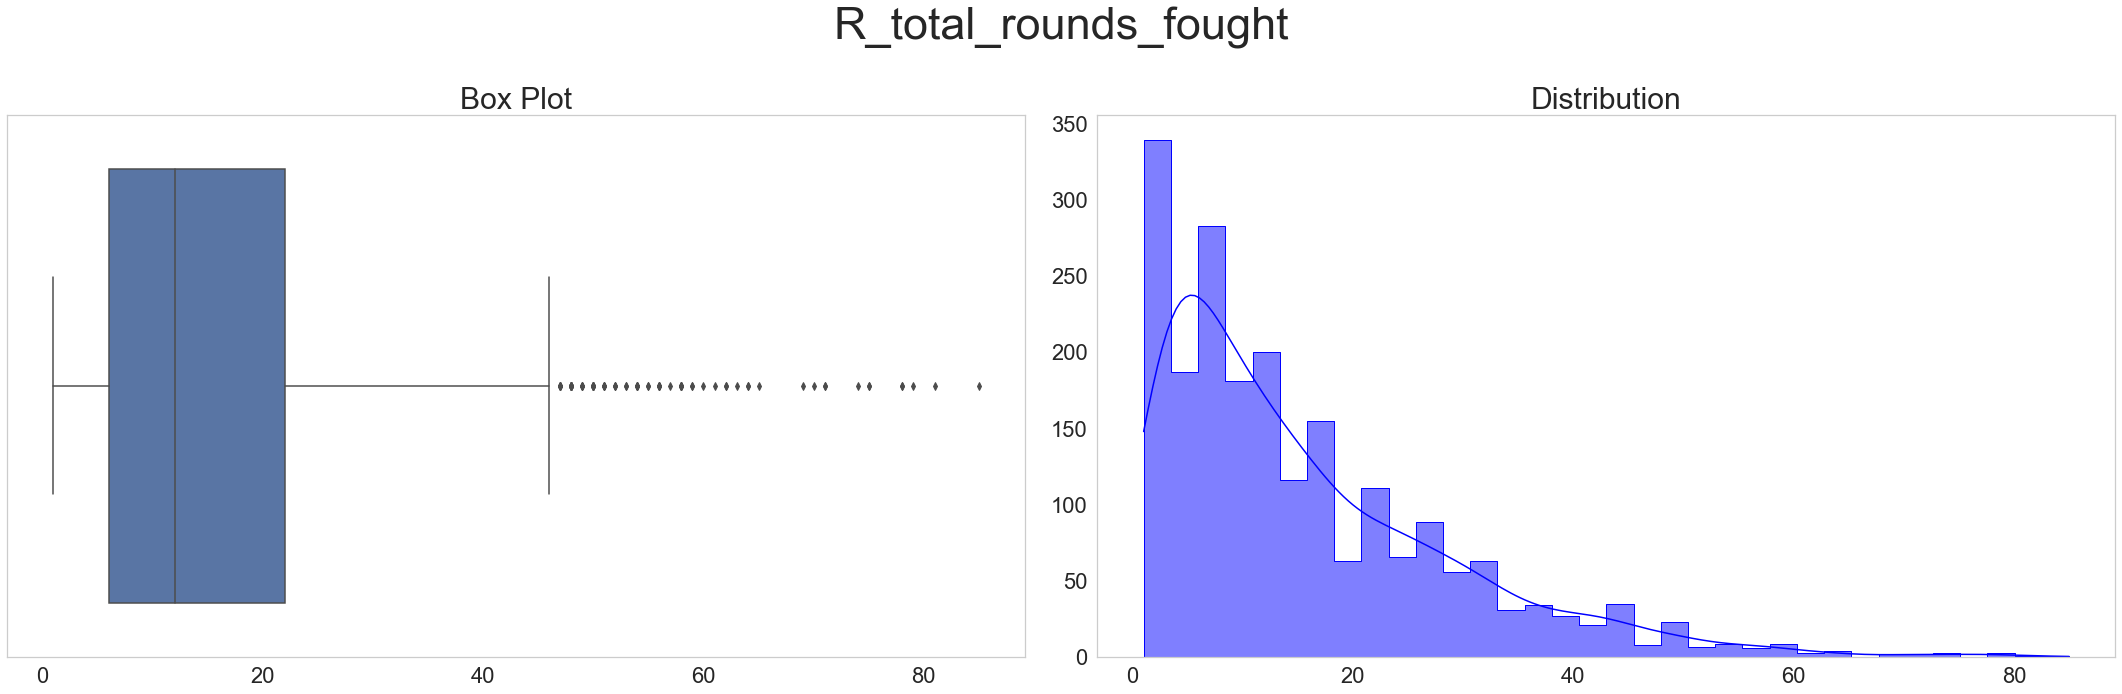

Summary Statistics for R_total_rounds_fought
count    2138.000000
mean       15.724509
std        13.527572
min         1.000000
25%         6.000000
50%        12.000000
75%        22.000000
max        85.000000
Name: R_total_rounds_fought, dtype: float64


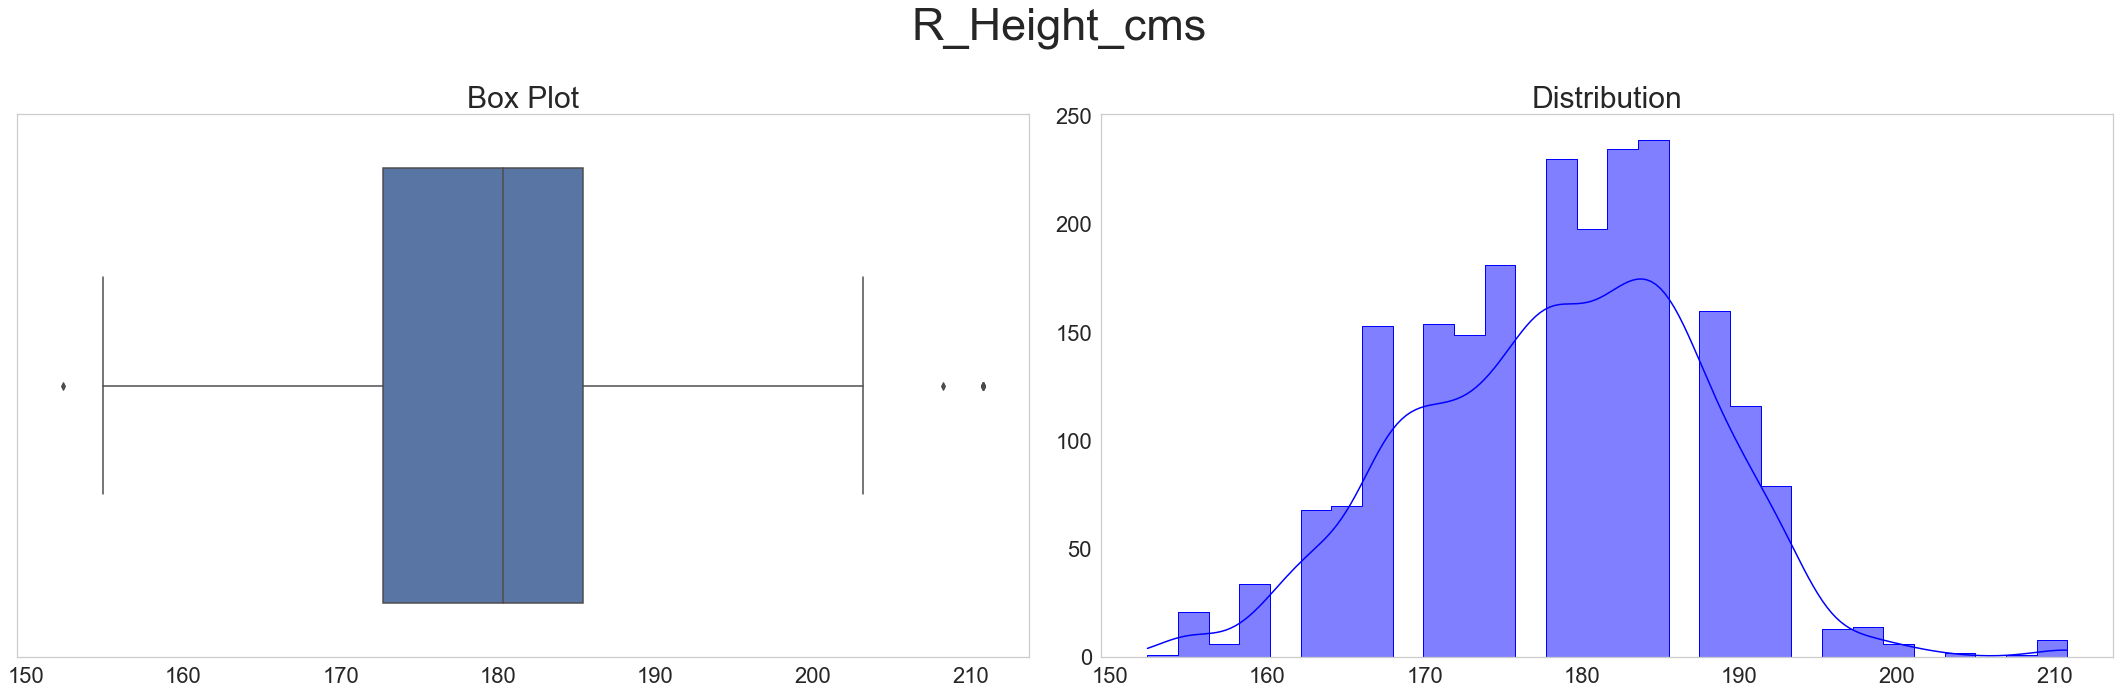

Summary Statistics for R_Height_cms
count    2138.000000
mean      178.603106
std         9.153692
min       152.400000
25%       172.720000
50%       180.340000
75%       185.420000
max       210.820000
Name: R_Height_cms, dtype: float64


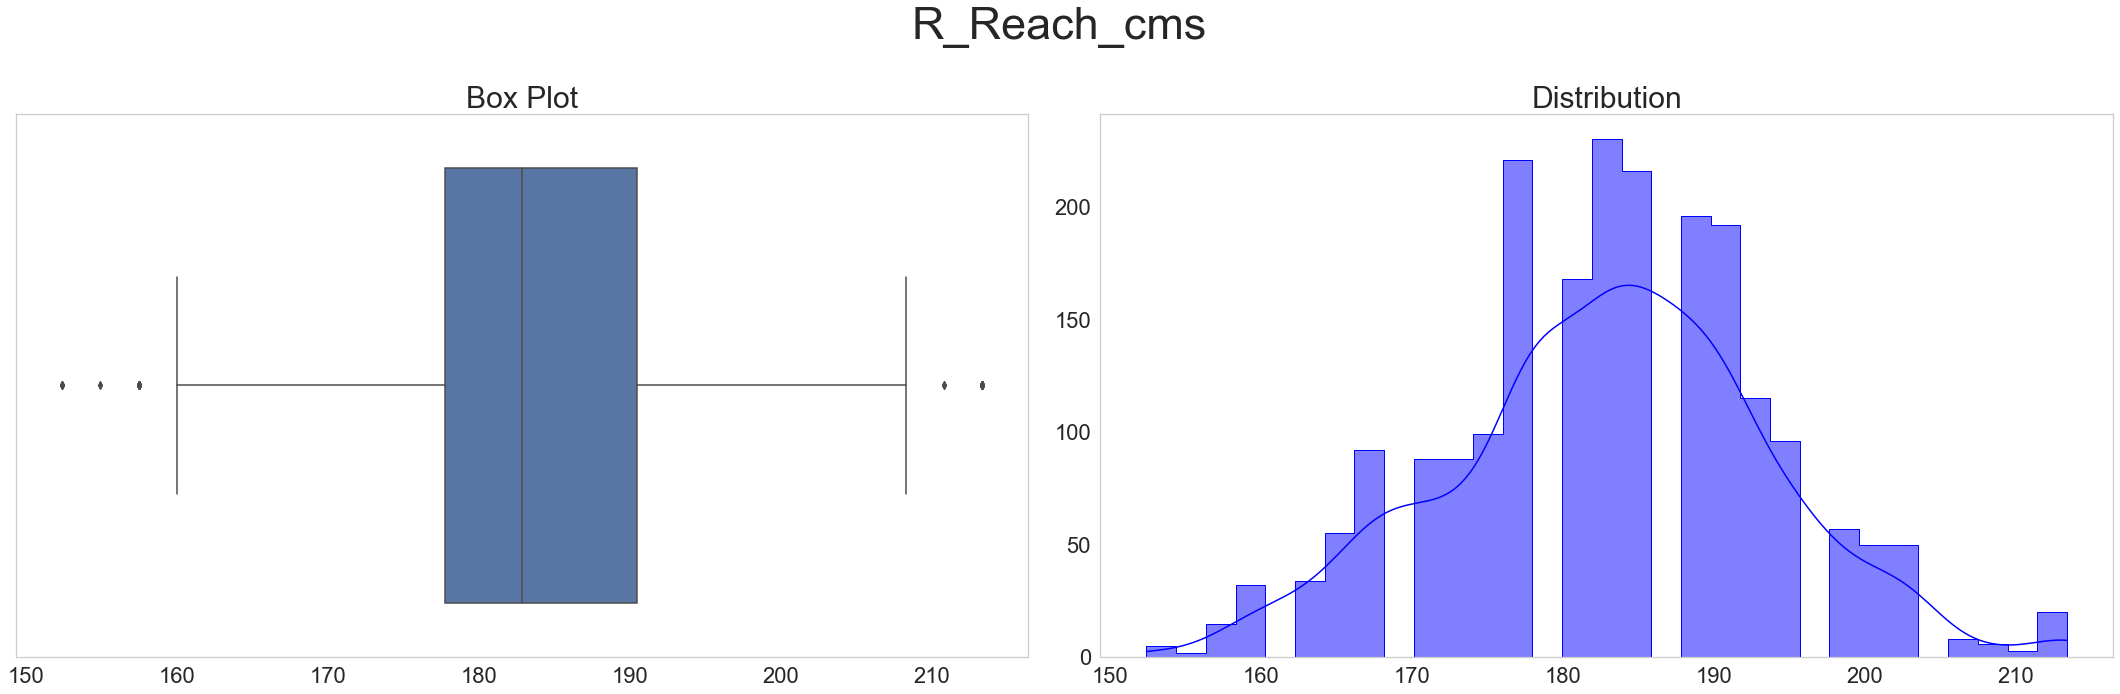

Summary Statistics for R_Reach_cms
count    2138.000000
mean      183.109289
std        10.701186
min       152.400000
25%       177.800000
50%       182.880000
75%       190.500000
max       213.360000
Name: R_Reach_cms, dtype: float64


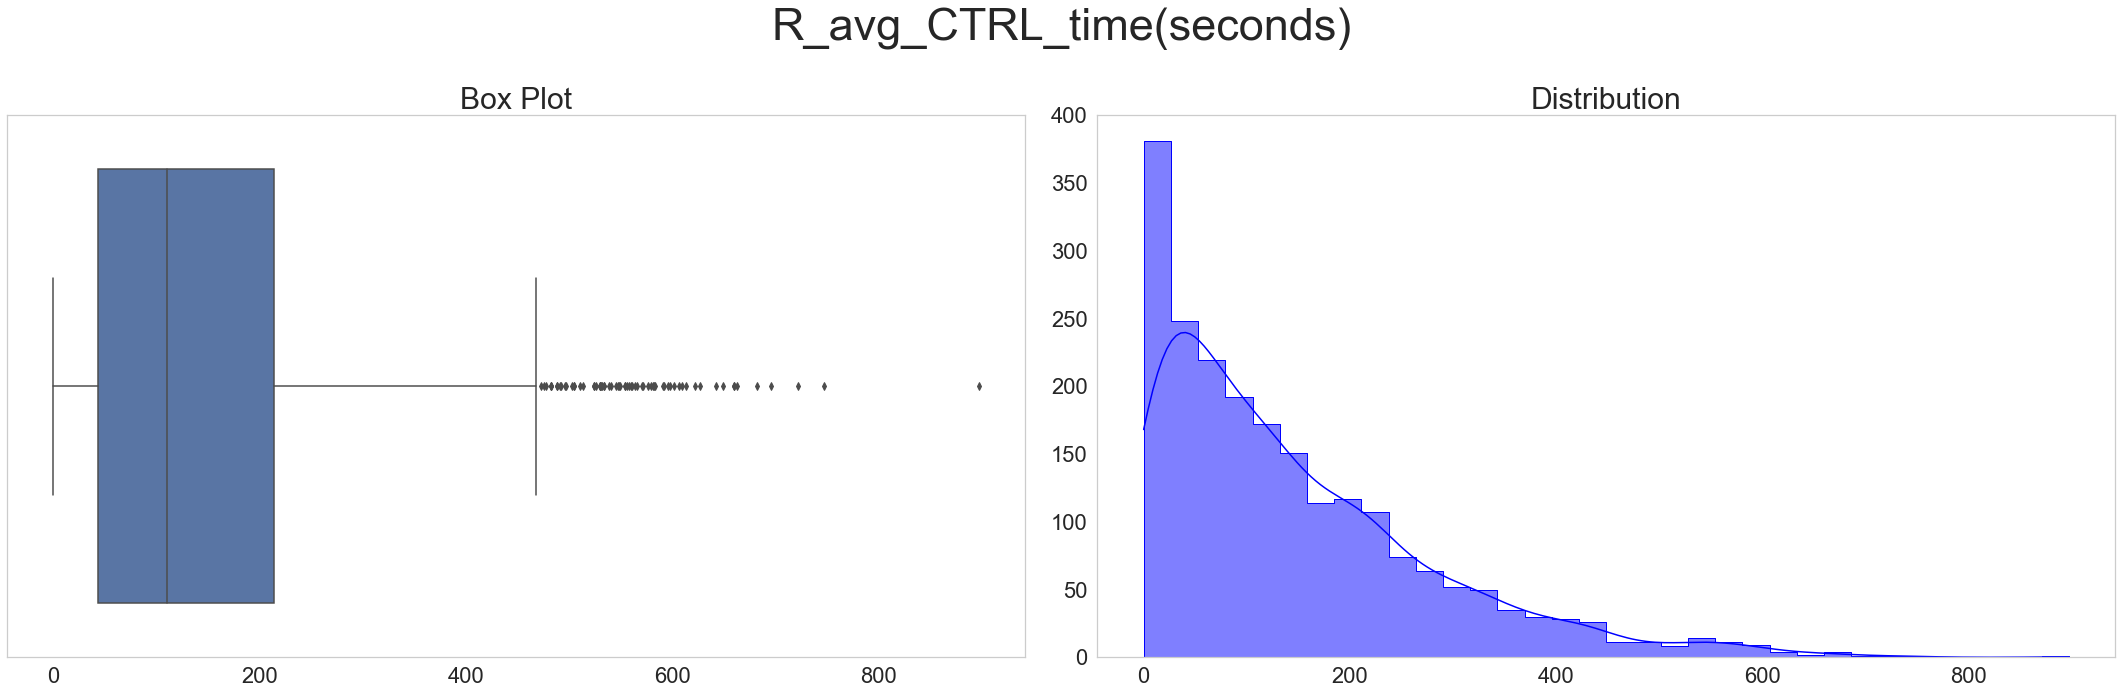

Summary Statistics for R_avg_CTRL_time(seconds)
count    2138.000000
mean      146.434097
std       134.287190
min         0.000000
25%        43.000000
50%       109.636719
75%       213.437500
max       897.359375
Name: R_avg_CTRL_time(seconds), dtype: float64


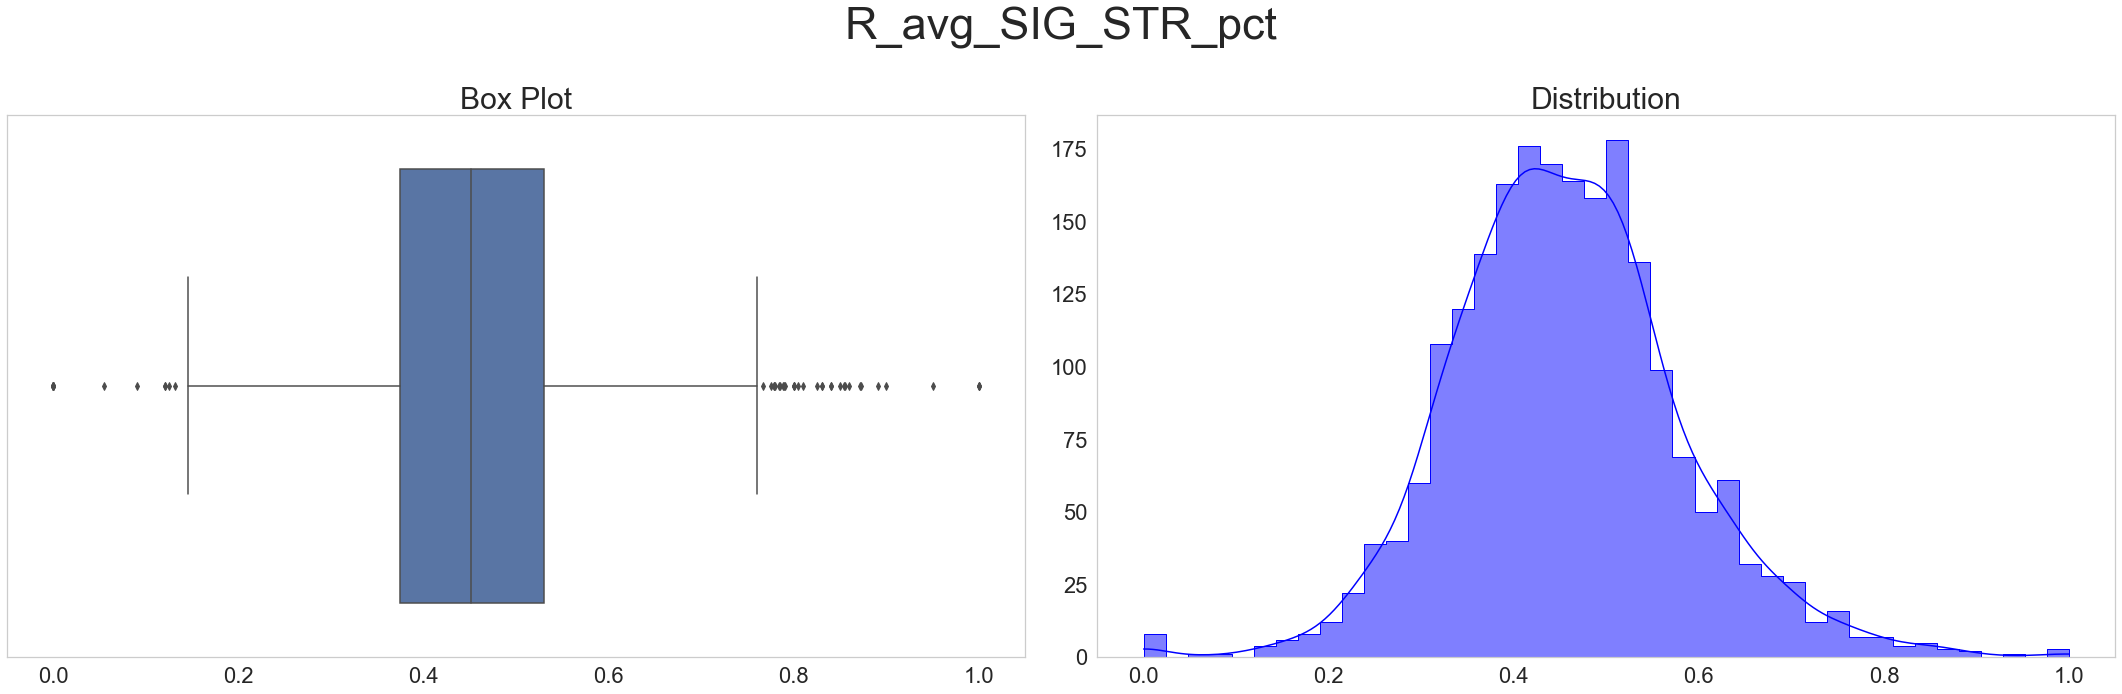

Summary Statistics for R_avg_SIG_STR_pct
count    2138.000000
mean        0.456273
std         0.125279
min         0.000000
25%         0.374387
50%         0.450948
75%         0.529785
max         1.000000
Name: R_avg_SIG_STR_pct, dtype: float64


In [10]:
univariate_study = ['R_avg_SUB_ATT','R_total_rounds_fought','R_Height_cms','R_Reach_cms','R_avg_CTRL_time(seconds)','R_avg_SIG_STR_pct']

for i in univariate_study:
    explore_univariate(train, i)
    print(f'Summary Statistics for {i}\n{train[i].describe()}')

In [11]:
from plotly.offline import iplot
import plotly.graph_objects as go

values = df.Winner.value_counts()
labels = df.Winner.unique()
colors = ['red', 'blue', 'green']
trace = go.Pie(labels=labels, 
               values=values,
                marker=dict(colors=colors) 
              )
layout = go.Layout(title='Winner Distribution by Corner Color')
fig = go.Figure(data=trace, layout=layout)
iplot(fig)


### Takeaways

- Stance - majority are orthodox
- Majority of classes are Featherweight and lightweight
- Sig str pct is normally distributed
- Avg takedown is right skewed
- Avg sig str att is right skewed
- Majority of wins are determined by majority decision
- More wins by submission then tko
- Height and reach are almost normally distributed

# Bivariate Exploration

Winner and submission attempts


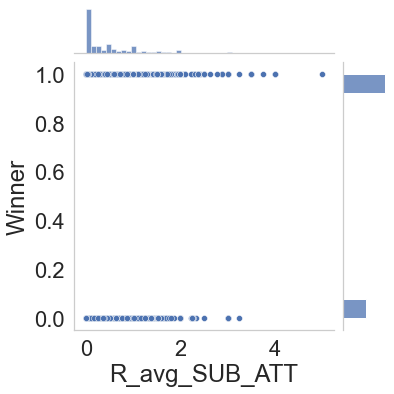

In [12]:
#Winner and submission attempts
print('Winner and submission attempts')
sns.jointplot(x='R_avg_SUB_ATT', y='Winner', data=train)
plt.xlabel('R_avg_SUB_ATT')
plt.ylabel('Winner')
plt.show()

In [13]:
null_hypothesis = "no difference in a winner with more then one submission attempt vs no submission attempts"
alternative_hypothesis = "there is a difference in a winner with more then one submission attempt vs no submission attempts"
a = 0.05 #a for alpha 

subattempt=train[train.R_avg_SUB_ATT>1].Winner
no_subattempt = train[train.R_avg_SUB_ATT<1].Winner
t, p = stats.ttest_ind(subattempt, no_subattempt)
print(p)
if p < a:
    print(f'Reject null hypothesis that: {null_hypothesis}')
    print (f'There is evidence to suggest: {alternative_hypothesis}')
else:
    print(f'Fail to reject null hypothesis that: {null_hypothesis} There is not sufficient evidence to reject it.')

0.019454658099556564
Reject null hypothesis that: no difference in a winner with more then one submission attempt vs no submission attempts
There is evidence to suggest: there is a difference in a winner with more then one submission attempt vs no submission attempts


Winner and Total Rounds Fought


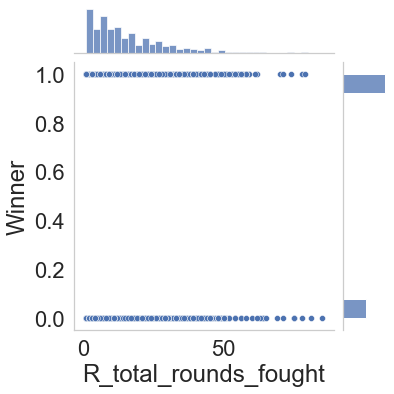

In [14]:
#Winner and total rounds fought
print('Winner and Total Rounds Fought')
sns.jointplot(x='R_total_rounds_fought', y='Winner', data=train)
plt.xlabel('R_total_rounds_fought')
plt.ylabel('Winner')
plt.show()

In [15]:
null_hypothesis = "no difference in a winner with more then 16 rounds fought vs less then 16 rounds fought"
alternative_hypothesis = "there is a difference in a winner with more then 16 rounds fought vs less then 16 rounds fought"
a = 0.05 #a for alpha 

morerds=train[train.R_total_rounds_fought>16].Winner
lessrds = train[train.R_total_rounds_fought<16].Winner
t, p = stats.ttest_ind(morerds, lessrds)
print(p)
if p < a:
    print(f'Reject null hypothesis that: {null_hypothesis}')
    print (f'There is evidence to suggest: {alternative_hypothesis}')
else:
    print(f'Fail to reject null hypothesis that: {null_hypothesis} There is not sufficient evidence to reject it.')

0.00013931464146878204
Reject null hypothesis that: no difference in a winner with more then 16 rounds fought vs less then 16 rounds fought
There is evidence to suggest: there is a difference in a winner with more then 16 rounds fought vs less then 16 rounds fought


In [16]:
null_hypothesis = "no difference in a winner with more then 16 rounds fought vs less then 16 rounds fought"
alternative_hypothesis = "there is a difference in a winner with more then 16 rounds fought vs less then 16 rounds fought"
a = 0.05 #a for alpha 

morerds=train[train.R_total_rounds_fought>16].Winner
lessrds = train[train.R_total_rounds_fought<16].Winner
t, p = stats.ttest_ind(morerds, lessrds)
print(p)
if p < a:
    print(f'Reject null hypothesis that: {null_hypothesis}')
    print (f'There is evidence to suggest: {alternative_hypothesis}')
else:
    print(f'Fail to reject null hypothesis that: {null_hypothesis} There is not sufficient evidence to reject it.')

0.00013931464146878204
Reject null hypothesis that: no difference in a winner with more then 16 rounds fought vs less then 16 rounds fought
There is evidence to suggest: there is a difference in a winner with more then 16 rounds fought vs less then 16 rounds fought


Winner and Reach


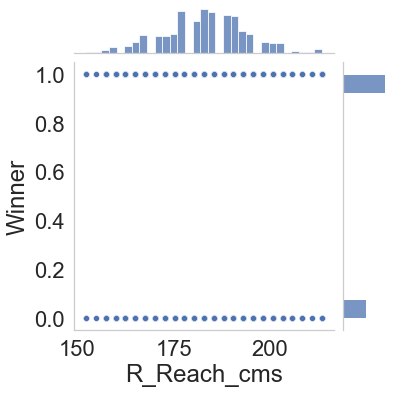

In [17]:
#Winner and reach
print('Winner and Reach')
sns.jointplot(x='R_Reach_cms', y='Winner', data=train)
plt.xlabel('R_Reach_cms')
plt.ylabel('Winner')
plt.show()

In [18]:
null_hypothesis = "no difference in a winner with a reach longer then 183 cm vs someone who has less reach"
alternative_hypothesis = "there is a difference in a winner with a reach longer then 183 cm vs someone who has less reach"
a = 0.05 #a for alpha 

more_reach=train[train.R_Reach_cms>183].Winner
less_reach = train[train.R_Reach_cms<183].Winner
t, p = stats.ttest_ind(more_reach, less_reach)
print(p)
if p < a:
    print(f'Reject null hypothesis that: {null_hypothesis}')
    print (f'There is evidence to suggest: {alternative_hypothesis}')
else:
    print(f'Fail to reject null hypothesis that: {null_hypothesis} There is not sufficient evidence to reject it.')

0.5637656368950537
Fail to reject null hypothesis that: no difference in a winner with a reach longer then 183 cm vs someone who has less reach There is not sufficient evidence to reject it.


Winner and Significant Strikes


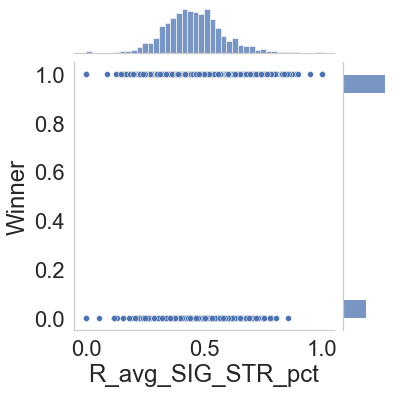

In [19]:
#Winner and significant strikes
print('Winner and Significant Strikes')
sns.jointplot(x='R_avg_SIG_STR_pct', y='Winner', data=train)
plt.xlabel('R_avg_SIG_STR_pct')
plt.ylabel('Winner')
plt.show()

In [20]:
null_hypothesis = "no difference in a winner with a signifcant strike percentage over 50% vs less then 50%"
alternative_hypothesis = "there is a difference in a winner with a signifcant strike percentage over 50% vs less then 50%"
a = 0.05 #a for alpha 

more_stri=train[train.R_avg_SIG_STR_pct>.50].Winner
less_stri = train[train.R_avg_SIG_STR_pct<.50].Winner
t, p = stats.ttest_ind(more_stri, less_stri)
print(p)
if p < a:
    print(f'Reject null hypothesis that: {null_hypothesis}')
    print (f'There is evidence to suggest: {alternative_hypothesis}')
else:
    print(f'Fail to reject null hypothesis that: {null_hypothesis} There is not sufficient evidence to reject it.')

9.65027270677872e-05
Reject null hypothesis that: no difference in a winner with a signifcant strike percentage over 50% vs less then 50%
There is evidence to suggest: there is a difference in a winner with a signifcant strike percentage over 50% vs less then 50%


## Multivariate Analysis

In [21]:
cat_vars = ['title_bout','weight_class','R_Stance','R_win_by_Submission']
quant_vars = ['R_Height_cms','R_Reach_cms','R_avg_SIG_STR_pct','R_avg_SUB_ATT']

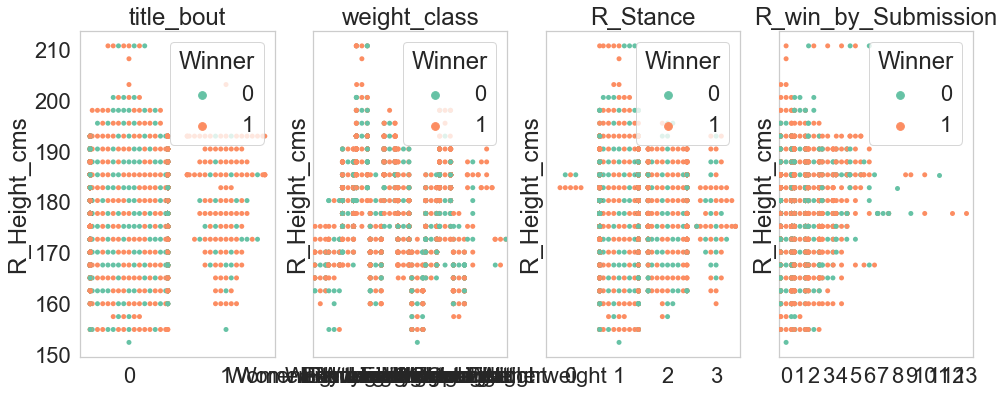

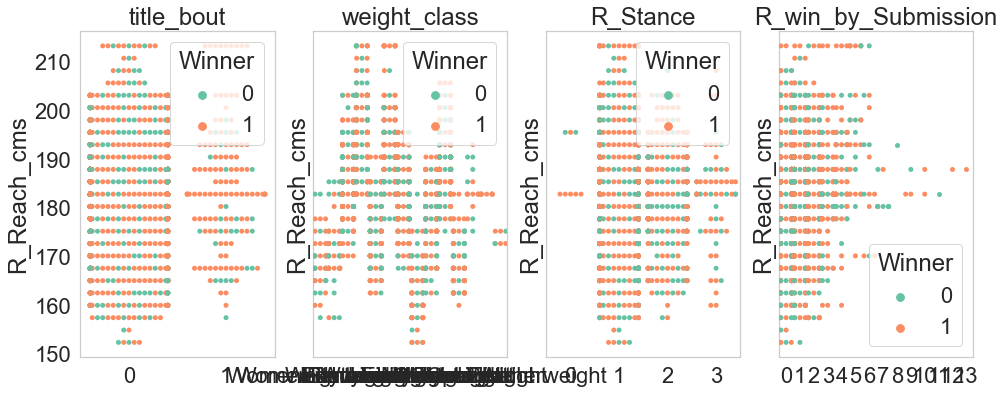

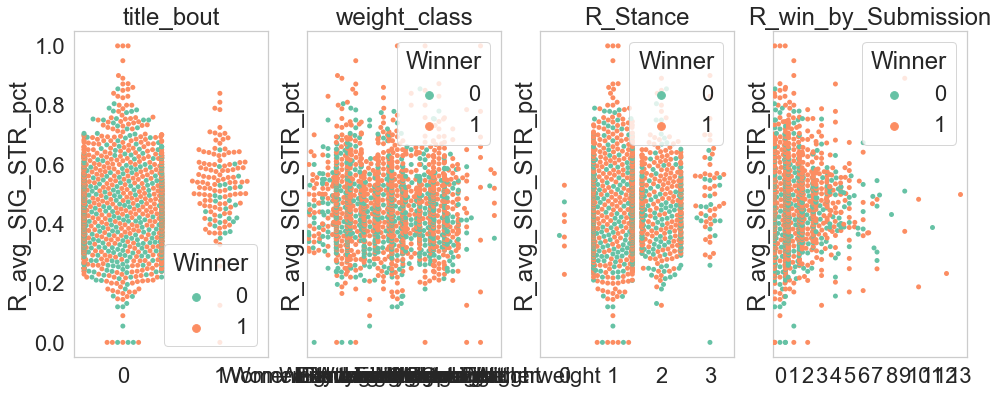

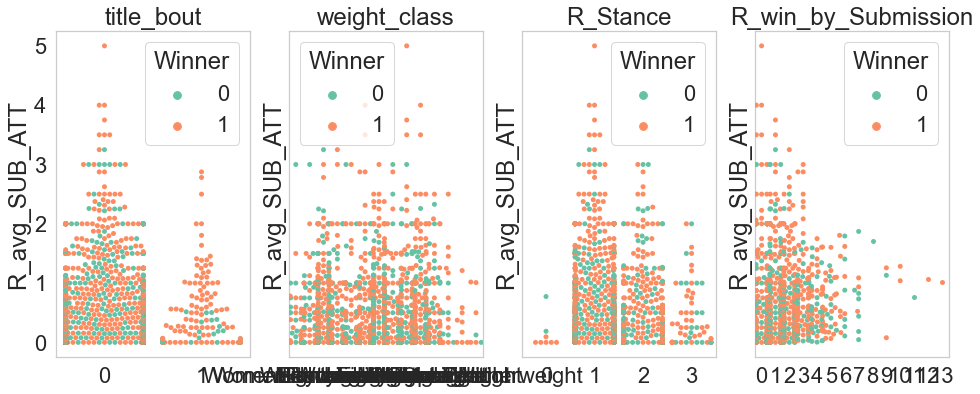

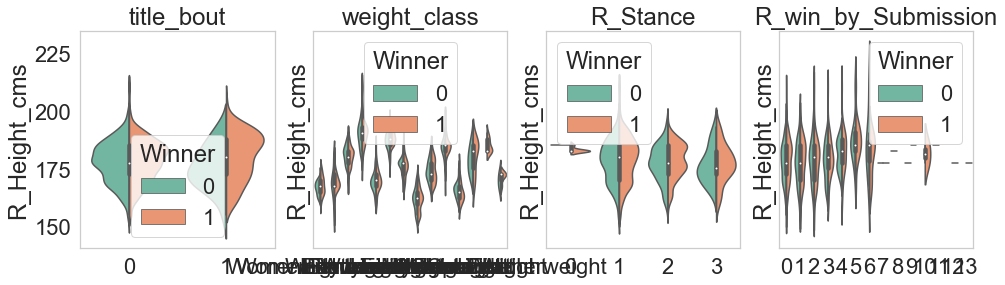

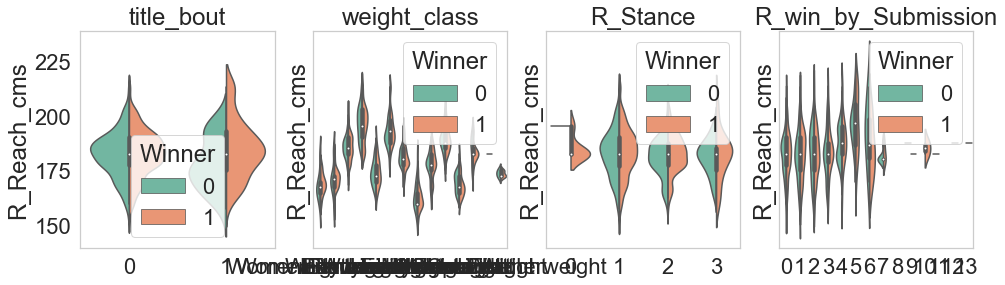

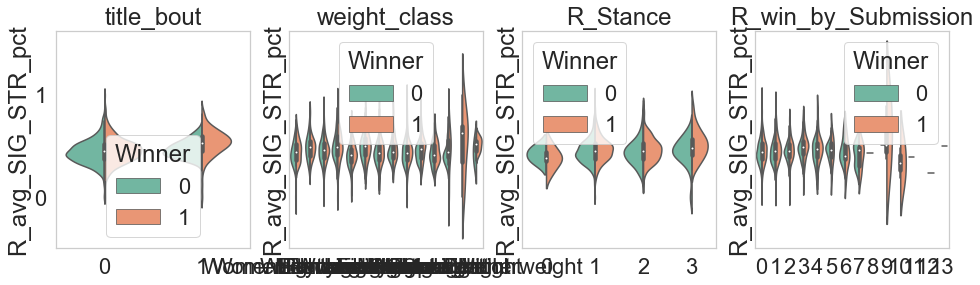

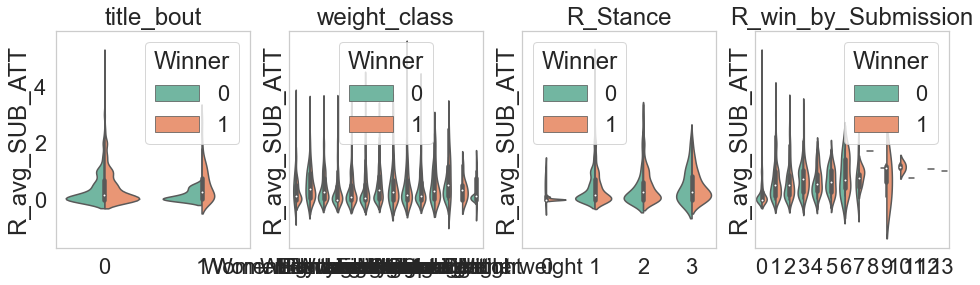

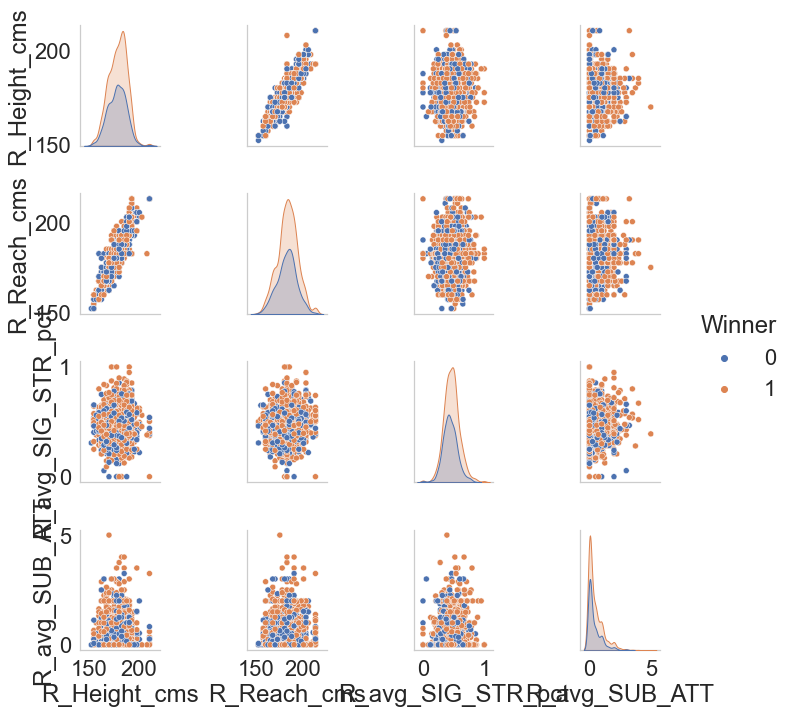

In [22]:
target = 'Winner'
explore_multivariate(train, target, cat_vars, quant_vars)

<AxesSubplot:title={'center':'Feautures Correlating with Winner'}>

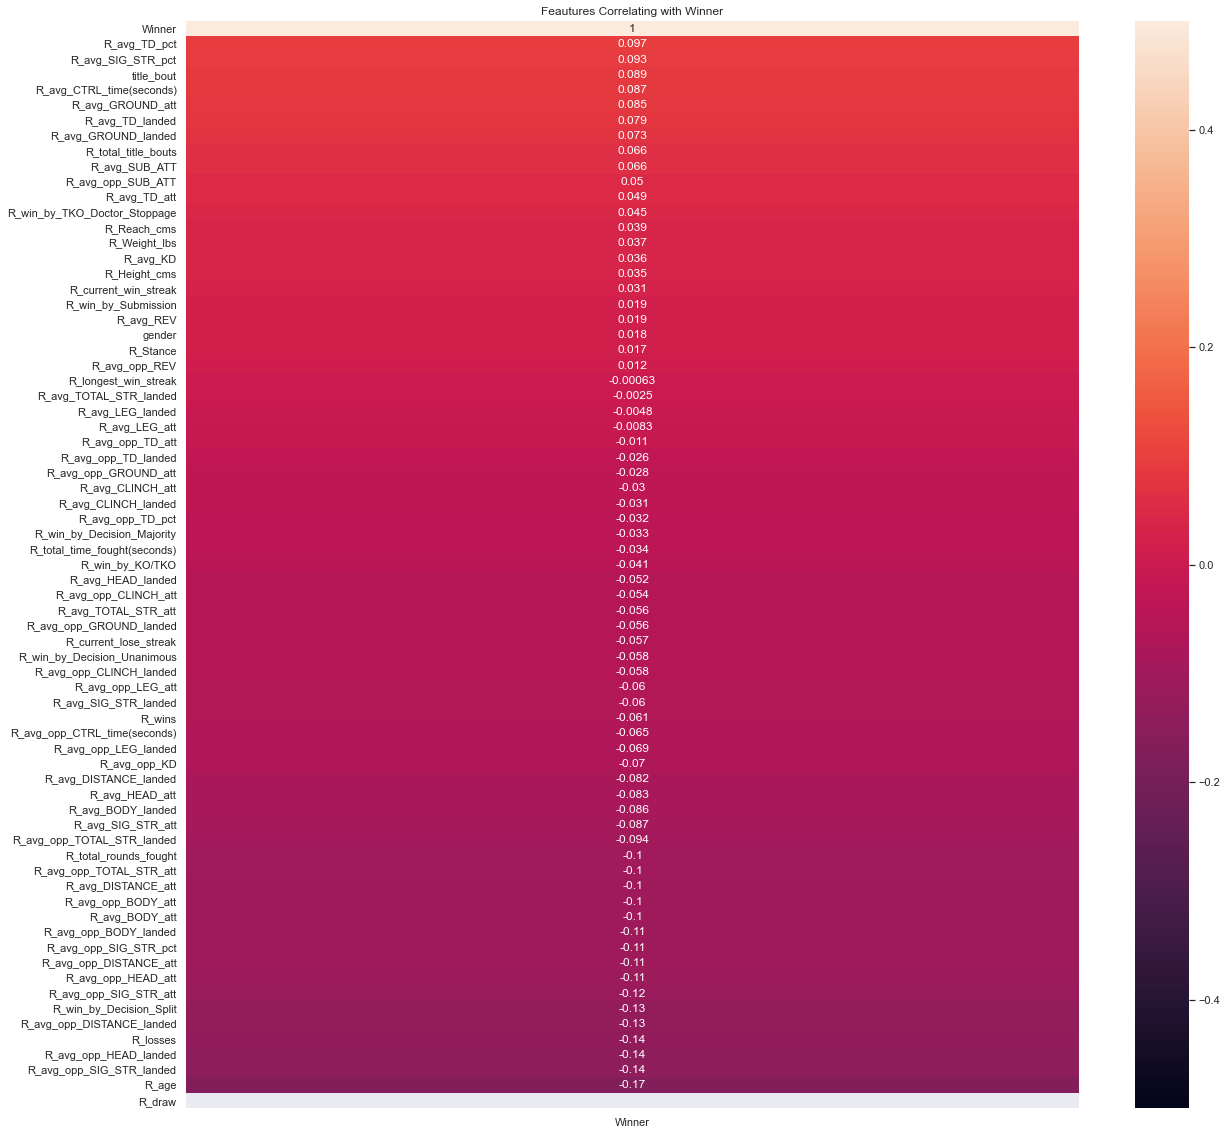

In [23]:
get_ufc_heatmap(train)

### Takeaways

- I found that There is evidence to suggest there is a difference in a winner with more then one submission attempt vs   no submission attempts

- There is evidence to suggest there is a difference in a winner with more then 16 rounds fought vs less then 16         rounds fought

- There is evidence to suggest there is a difference in a winner with more then 16 rounds fought vs less then 16         rounds fought

- There is evidence to suggest there is a difference in a winner with a signifcant strike percentage over 50% vs less   then 50%


# Model

In [24]:
# Let's begin by establishing a baseline accuracy.

In [25]:
#x_cols are the features I'm focusing on to predict whether an oppenant wins or not. 
#y_col is our target
x_col = ['R_avg_SUB_ATT', 'R_Reach_cms','R_avg_SIG_STR_pct', 'R_avg_GROUND_att', 'R_avg_CTRL_time(seconds)']
y_col = 'Winner'

In [26]:
#splitting our data based on our features
X_train, y_train = train[x_col], train[y_col]

X_validate, y_validate = validate[x_col], validate[y_col]

X_test, y_test = test[x_col], test[y_col]



In [27]:
#Since I can see most fighters won, I will set my winning prediction to 1 for everyone. 
train['baseline_prediction'] = 1

baseline_score = round(accuracy_score(train.Winner, train.baseline_prediction),2)
print(f'Our baseline score is {baseline_score}')

Our baseline score is 0.65


Predictions end up 4 different ways:

- TP: True Positive. We predicted the fighter would win & they did.
- TN: True Negative. We predicted the fighter would lose & they did.
- FP: False Positive. We predicted the fighter would win & they didn't.
- FN: False Negative. We predicted the fighter would lose & they didn't.

In [28]:
# Decision Tree Model

In [29]:
def get_metrics_binary(clf):
    '''
    get_metrics_binary takes in a confusion matrix (cnf) for a binary classifier and prints out metrics based on
    values in variables named X_train, y_train, and y_pred.
    
    return: a classification report as a transposed DataFrame
    '''
    accuracy = clf.score(X_train, y_train)
    class_report = pd.DataFrame(classification_report(y_train, y_pred, output_dict=True)).T
    conf = confusion_matrix(y_train, y_pred)
    tpr = conf[1][1] / conf[1].sum()
    fpr = conf[0][1] / conf[0].sum()
    tnr = conf[0][0] / conf[0].sum()
    fnr = conf[1][0] / conf[1].sum()
    print(f'''
    The accuracy for our model is {accuracy:.4}
    The True Positive Rate is {tpr:.3}, The False Positive Rate is {fpr:.3},
    The True Negative Rate is {tnr:.3}, and the False Negative Rate is {fnr:.3}
    ''')
    return class_report

In [30]:
#Going to create a decision tree under 'tree', I used max leaf nodes of 15 and max depth of 2. 
tree = DecisionTreeClassifier(max_leaf_nodes=15, max_depth=2)

In [31]:
#fit it to my training sample
tree.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=2, max_leaf_nodes=15)

In [32]:
#training and validate score, I want them to be better than the baseline and close to each other so I'm not overfitting
print(f'training score: {tree.score(X_train, y_train):.2%}')
print(f'validate score: {tree.score(X_validate, y_validate):.2%}')

training score: 64.78%
validate score: 64.99%


In [33]:
# make prediction on train observations
y_pred = tree.predict(X_train)

In [34]:
get_metrics_binary(tree)


    The accuracy for our model is 0.6478
    The True Positive Rate is 1.0, The False Positive Rate is 1.0,
    The True Negative Rate is 0.0, and the False Negative Rate is 0.0
    


precision    recall  f1-score      support
0              0.000000  0.000000  0.000000   753.000000
1              0.647802  1.000000  0.786262  1385.000000
accuracy       0.647802  0.647802  0.647802     0.647802
macro avg      0.323901  0.500000  0.393131  2138.000000
weighted avg   0.419647  0.647802  0.509342  2138.000000

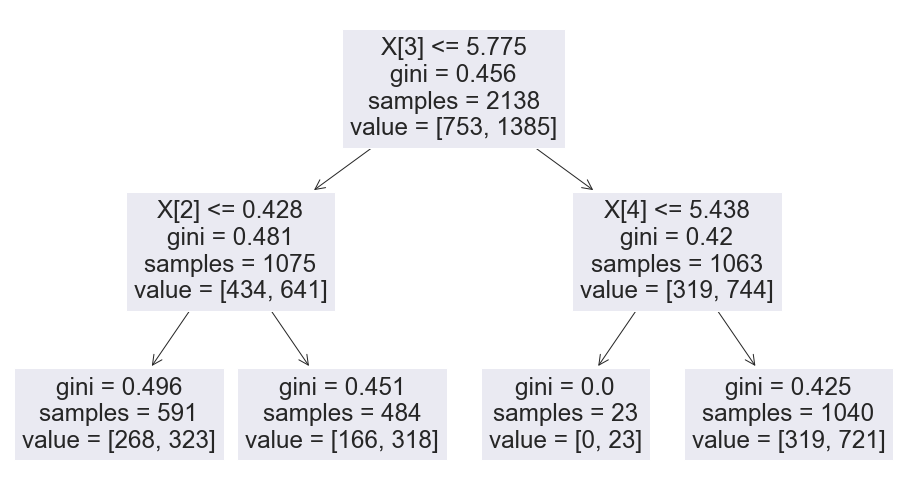

In [35]:
#illustration of the tree
plt.figure(figsize=(16,9))
plot_tree(tree)
plt.show()

In [36]:
#making a prediction for winners, and also a classification report.
y_pred = tree.predict(X_train)
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       753
           1       0.65      1.00      0.79      1385

    accuracy                           0.65      2138
   macro avg       0.32      0.50      0.39      2138
weighted avg       0.42      0.65      0.51      2138



In [37]:
print('Scores for Decision Tree')
print('---------------------------')
print(f'Baseline score is {baseline_score}')
print(f'accuracy score is {round(accuracy_score(y_train, y_pred),2)}')
print(f'precision score is {round(precision_score(y_train, y_pred, pos_label =0),2)}')
print(f'recall score is {round(sklearn.metrics.recall_score(y_train, y_pred, pos_label =0),2)}')

Scores for Decision Tree
---------------------------
Baseline score is 0.65
accuracy score is 0.65
precision score is 0.0
recall score is 0.0


# Logistic Regression

In [38]:
#set parameters for logistic regression, fit it, made predictions, and printed training and validate scores.

logit = LogisticRegression(C= 10, random_state =123)
logit.fit(X_train, y_train)
y_pred = logit.predict(X_train)
print(f'training score: {logit.score(X_train, y_train):.2%}')
print(f'validate score: {logit.score(X_validate, y_validate):.2%}')

training score: 64.59%
validate score: 64.99%


In [39]:
#classification report.
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.25      0.00      0.01       753
           1       0.65      1.00      0.78      1385

    accuracy                           0.65      2138
   macro avg       0.45      0.50      0.39      2138
weighted avg       0.51      0.65      0.51      2138



In [40]:
get_metrics_binary(logit)


    The accuracy for our model is 0.6459
    The True Positive Rate is 0.996, The False Positive Rate is 0.997,
    The True Negative Rate is 0.00266, and the False Negative Rate is 0.00433
    


precision    recall  f1-score      support
0              0.250000  0.002656  0.005256   753.000000
1              0.647418  0.995668  0.784637  1385.000000
accuracy       0.645931  0.645931  0.645931     0.645931
macro avg      0.448709  0.499162  0.394947  2138.000000
weighted avg   0.507448  0.645931  0.510141  2138.000000

In [41]:
print('Scores for Logistic Regression!')
print('---------------------------')
print(f'Baseline score is {baseline_score}')
print(f'accuracy score is {round(sklearn.metrics.accuracy_score(y_train, y_pred),2)}')
print(f'precision score is {round(sklearn.metrics.precision_score(y_train, y_pred, pos_label =0),2)}')
print(f'recall score is {round(sklearn.metrics.recall_score(y_train, y_pred, pos_label =0),2)}')

Scores for Logistic Regression!
---------------------------
Baseline score is 0.65
accuracy score is 0.65
precision score is 0.25
recall score is 0.0


# KNN

In [42]:
#setting up and fitting my KNN model 
knn = KNeighborsClassifier(n_neighbors = 30)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=30)

In [43]:
#let's see the training and validate scores
print(f'training score: {knn.score(X_train, y_train):.2%}')
print(f'validate score: {knn.score(X_validate, y_validate):.2%}')

training score: 65.39%
validate score: 64.34%


In [44]:
#classification report
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.25      0.00      0.01       753
           1       0.65      1.00      0.78      1385

    accuracy                           0.65      2138
   macro avg       0.45      0.50      0.39      2138
weighted avg       0.51      0.65      0.51      2138



In [45]:
get_metrics_binary(knn)


    The accuracy for our model is 0.6539
    The True Positive Rate is 0.996, The False Positive Rate is 0.997,
    The True Negative Rate is 0.00266, and the False Negative Rate is 0.00433
    


precision    recall  f1-score      support
0              0.250000  0.002656  0.005256   753.000000
1              0.647418  0.995668  0.784637  1385.000000
accuracy       0.645931  0.645931  0.645931     0.645931
macro avg      0.448709  0.499162  0.394947  2138.000000
weighted avg   0.507448  0.645931  0.510141  2138.000000

In [46]:
print('Scores for KNN!')
print('---------------------------')
print(f'Baseline score is {baseline_score}')
print(f'accuracy score is {round(sklearn.metrics.accuracy_score(y_train, y_pred),2)}')
print(f'precision score is {round(sklearn.metrics.precision_score(y_train, y_pred, pos_label =0),2)}')
print(f'recall score is {round(sklearn.metrics.recall_score(y_train, y_pred, pos_label =0),2)}')

Scores for KNN!
---------------------------
Baseline score is 0.65
accuracy score is 0.65
precision score is 0.25
recall score is 0.0


## Running our algorithms on our unseen data

In [47]:
# Testing different algorithms/models
use_cross_val = True
dict_model_accuracy = dict()
algorithms = ['knn', 'rfc', 'logistic_regression', 'svm', 'naive_bayes']
for algorithm in algorithms:
    if algorithm == 'knn':
        classifier = KNeighborsClassifier(n_neighbors=55, metric='minkowski', p=10)
    elif algorithm == 'rfc':
        classifier = RandomForestClassifier(n_estimators=30, criterion='gini', max_depth=2)
    elif algorithm == 'logistic_regression':
        classifier = LogisticRegression(solver='sag')
    elif algorithm == 'svm':
        classifier = svm.SVC(kernel='rbf')
    elif algorithm == 'naive_bayes':
        classifier = naive_bayes.GaussianNB()

    model = classifier.fit(X_train, y_train)
    
        
        # Evaluate with just the model
    y_pred = model.predict(X_test)
        # cm = confusion_matrix(y_test, y_pred)
    model_accuracy = accuracy_score(y_true=y_test, y_pred=y_pred, normalize=True) * 100
    model_accuracy = round(model_accuracy, 2)
    dict_model_accuracy[algorithm] = model_accuracy
#
rename_dict = {
    'index': 'algorithm',
    0: 'accuracy_percentage'
}
df_accuracies = pd.DataFrame(dict_model_accuracy, index=[0]).T.reset_index().rename(mapper=rename_dict, axis=1)
df_accuracies = df_accuracies.sort_values(by='accuracy_percentage', ascending=False).reset_index(drop=True)

In [48]:
df_accuracies

algorithm  accuracy_percentage
0                  rfc                63.35
1  logistic_regression                63.35
2                  svm                63.35
3                  knn                62.70
4          naive_bayes                58.25

# Conclusion / Next Steps

- Based on the features average submission attempts ,reach ,average significant strikes, 'average ground attempts ,average control time(seconds) there is a 63% accuracy of predicting a winner. 

- My test accuracy of 63% did not beat my baseline of 65% 

- The chart above, I ran my test data on multiple machine learning algo's to get a visual

- With more time I would like to try different combinations or maybe use all the features